### SARIMA(WEEKLY)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator, DateFormatter

In [2]:
df = pd.read_csv('TIH Expenditure Data_cleaned.csv')

In [3]:
df.dtypes

INVOICE_NO                           object
INVOICE_DT                           object
Payment_Date                         object
PAYMENT_PARTY                        object
NARRATION                            object
INVOICE_VALUE_WITHOUT_GST_OR_TDS    float64
CGST                                float64
SGST                                float64
IGST                                float64
GROSS AMOUNT                        float64
P TAX (-)                           float64
TDS AMOUT (-)                       float64
ROUND UP (+)                        float64
ROUND OFF (-)                       float64
NET AMOUNT PAID                     float64
TDS PERCENTAGE                      float64
PAN NO                               object
PV DATE                              object
PV NO                                object
EXP TYPE                             object
EXPENSE HEAD                         object
PROJECT CODE                         object
GST_Rate                        

In [4]:
df['Payment_Date'] = pd.to_datetime(df['Payment_Date'], errors='coerce', format='mixed')

In [5]:
df_agg_weekly = df.groupby(pd.Grouper(key='Payment_Date', freq='W'))['GROSS AMOUNT'].sum().reset_index()
df_agg_weekly = df_agg_weekly.set_index('Payment_Date')
df_agg_weekly

,GROSS AMOUNT
Payment_Date,
2024-06-30,2197796.71
2024-07-07,1824504.86
2024-07-14,777945.50
2024-07-21,31672.99
2024-07-28,9350.00
2024-08-04,825874.00
2024-08-11,248876.03
2024-08-18,92029.90
2024-08-25,50401.30


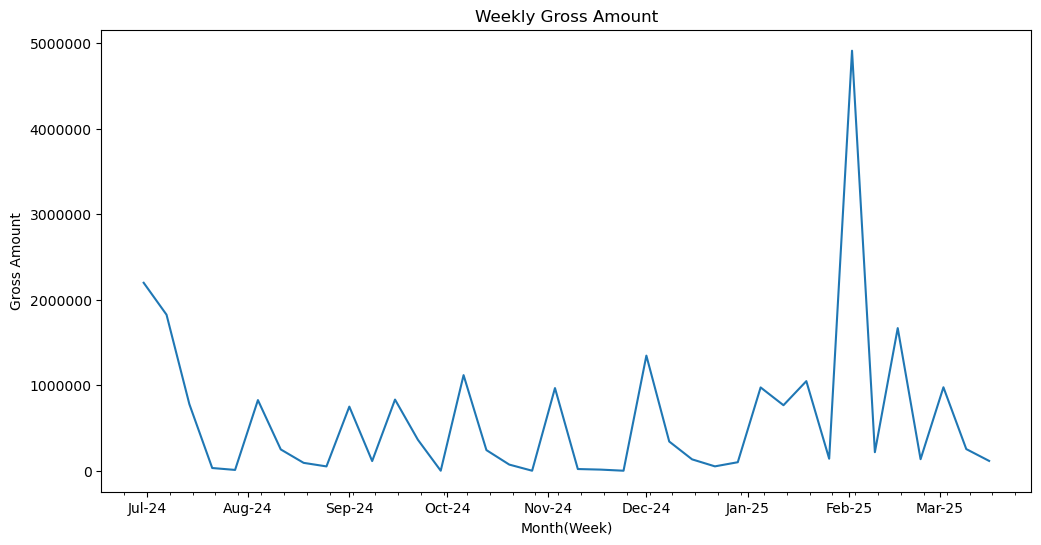

In [6]:
plt.figure(figsize = (12,6))
plt.plot(df_agg_weekly.index, df_agg_weekly['GROSS AMOUNT'])
plt.xlabel('Month(Week)')
plt.ylabel('Gross Amount')
ax=plt.gca()

ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))
ax.ticklabel_format(axis='y', style='plain')
plt.title('Weekly Gross Amount')
plt.savefig('WeeklyGrossAmount.png')
plt.show()

In [7]:
import pandas as pd

# Create expected weekly date range to check if the data is continuous in terms of weeks
full_range = pd.date_range(start=df_agg_weekly.index.min(), 
                           end=df_agg_weekly.index.max(), 
                           freq='W')

missing_weeks = full_range.difference(df_agg_weekly.index)

if missing_weeks.empty:
    print("The weekly data is continuous (no missing weeks).")
else:
    print(f"Missing weeks found: {len(missing_weeks)}")
    print(missing_weeks)


The weekly data is continuous (no missing weeks).


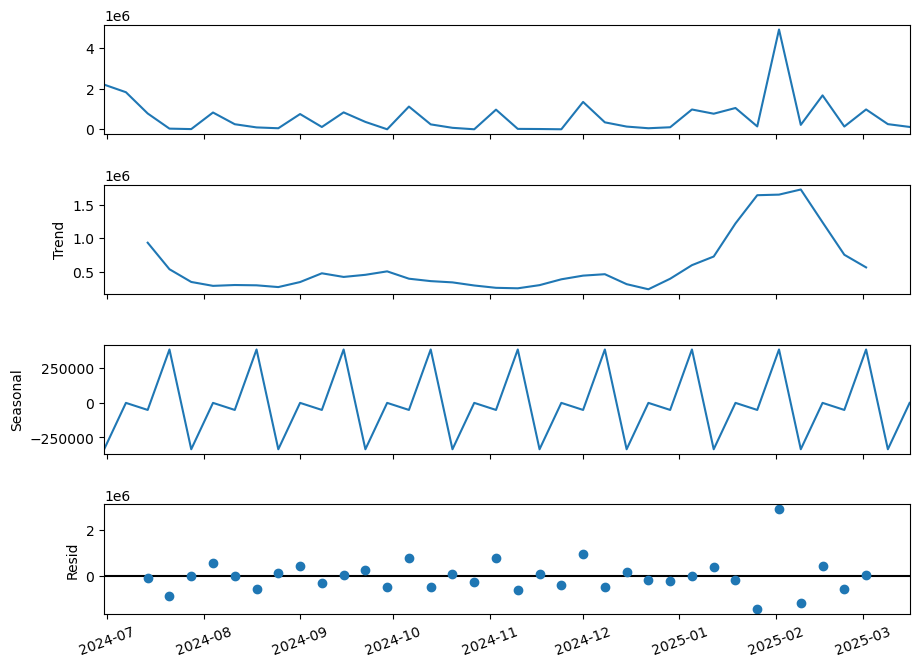

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

result = seasonal_decompose(df_agg_weekly, period=4)
fig = result.plot()
fig.set_size_inches(10, 8)  # Optional: make it larger
plt.xticks(rotation=20)
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin
plt.savefig('Decomposition.png', bbox_inches='tight')
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_agg_weekly.dropna())
# Extract and print the results
print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
print("Number of lags used: {}".format(result[2]))
print("Number of observations used: {}".format(result[3]))

# Critical values
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] <= 0.05:
    print("=> Reject the null hypothesis (H0): The series is stationary.")
else:
    print("=> Fail to reject the null hypothesis (H0): The series is non-stationary.")


ADF Statistic: -1.1654
p-value: 0.6883
Number of lags used: 8
Number of observations used: 29
Critical Value (1%): -3.6791
Critical Value (5%): -2.9679
Critical Value (10%): -2.6232
=> Fail to reject the null hypothesis (H0): The series is non-stationary.


In [10]:
ts = df_agg_weekly.diff().dropna()
result = adfuller(ts.dropna())
# Extract and print the results
print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
print("Number of lags used: {}".format(result[2]))
print("Number of observations used: {}".format(result[3]))
# Interpretation
if result[1] <= 0.05:
    print("=> Reject the null hypothesis (H0): The series is stationary.")
else:
    print("=> Fail to reject the null hypothesis (H0): The series is non-stationary.")

# Series becomes stationary after differencing it once. so, d=1.

ADF Statistic: -3.3786
p-value: 0.0117
Number of lags used: 7
Number of observations used: 29
=> Reject the null hypothesis (H0): The series is stationary.


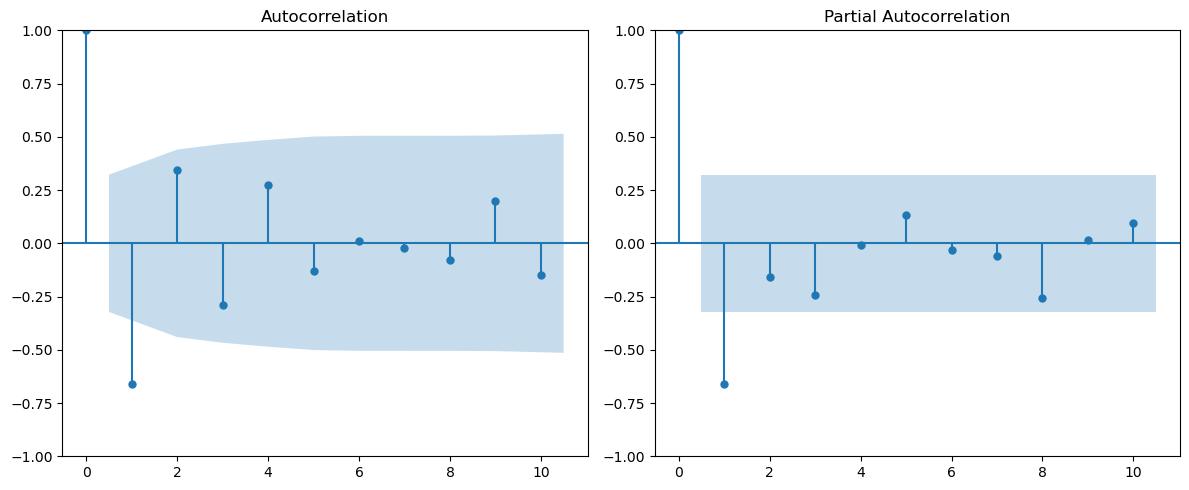

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# After necessary differencing (non-seasonal or seasonal)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(ts.dropna(), lags=10, ax=axes[0])
plot_pacf(ts.dropna(), lags=10, ax=axes[1])
plt.tight_layout()
plt.savefig('ACF,PACF.png')
plt.show()


In [12]:
train_data, test_data = df_agg_weekly['GROSS AMOUNT'][:-6], df_agg_weekly['GROSS AMOUNT'][-6:]
train_data.info()
print(len(train_data))
print(len(test_data))

<class 'pandas.core.series.Series'>
DatetimeIndex: 32 entries, 2024-06-30 to 2025-02-02
Series name: GROSS AMOUNT
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 512.0 bytes
32
6


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#p=1,q=1,s=4,d=0
model = SARIMAX(train_data, order=(0,1,1), seasonal_order=(1,1,1,7))

C:\Users\Srija Upadhyay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Srija Upadhyay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [14]:
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      GROSS AMOUNT   No. Observations:                   32
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -368.707
Date:                           Tue, 15 Jul 2025   AIC                            745.414
Time:                                   20:30:42   BIC                            750.127
Sample:                               06-30-2024   HQIC                           746.665
                                    - 02-02-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7535      0.681     -1.107      0.269      -2.088       0.581
ar.S.L7       -0.2794      1.603     -0.174

C:\Users\Srija Upadhyay\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Srija Upadhyay\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [15]:
predictions_sarima = results.predict(
    start = test_data.index[0],
    end = test_data.index[-1],
    dynamic=False)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mse = mean_squared_error(predictions_sarima, test_data)
mae = mean_absolute_error(predictions_sarima, test_data)

print(f"MAE: {mae}, MSE: {mse}")


def smape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    denominator = (np.abs(actual) + np.abs(forecast)) / 2.0
    diff = np.abs(actual - forecast) / denominator
    diff[denominator == 0] = 0.0  # avoid division by zero
    return 100 * np.mean(diff)
smape = smape(test_data, predictions_sarima)
print(f"SMAPE: {smape}")

MAE: 1273252.2477505736, MSE: 1961688754595.9998
SMAPE: 122.42308240074253


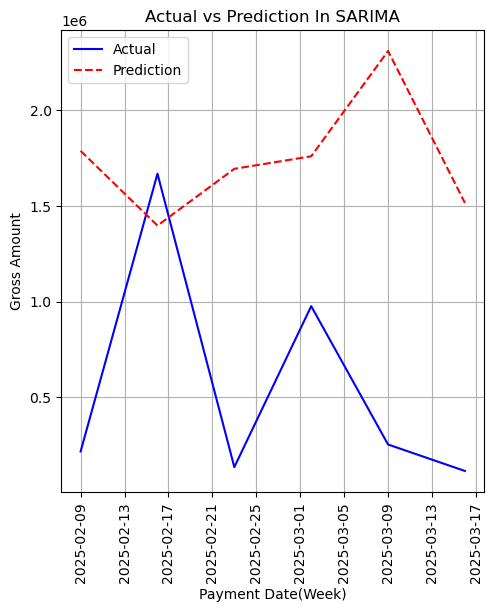

In [17]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(test_data.index, test_data.values, label='Actual', color = 'blue')
plt.plot(test_data.index, predictions_sarima.values, label='Prediction', color = 'red', linestyle = "--")
plt.title('Actual vs Prediction In SARIMA')
plt.xlabel('Payment Date(Week)')
plt.xticks(rotation=90)
plt.ylabel('Gross Amount')
plt.legend()
plt.grid()
plt.show()

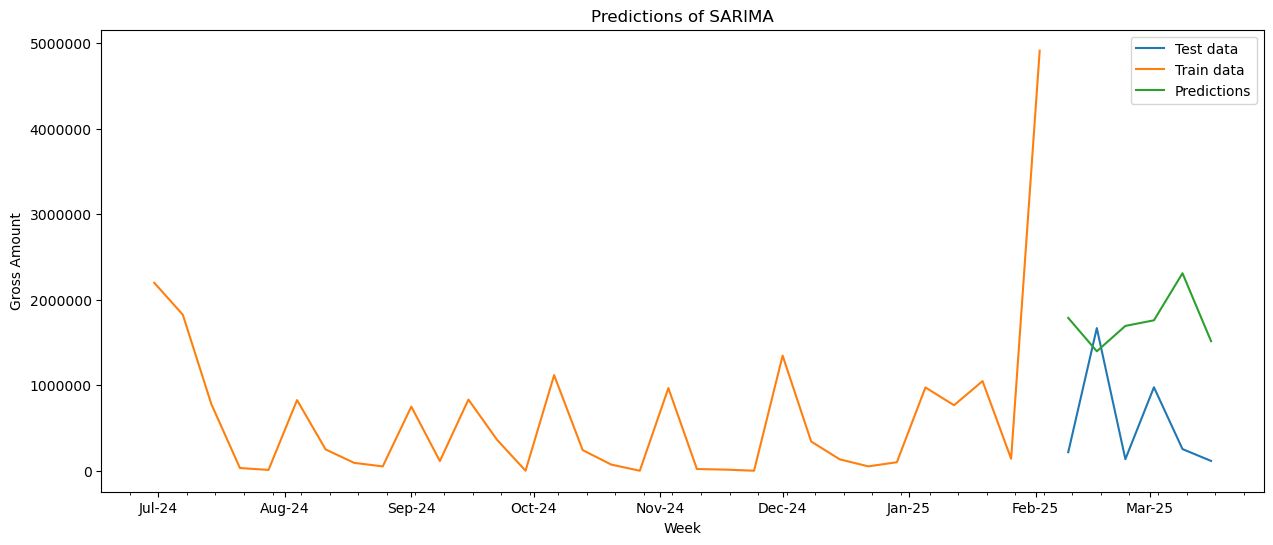

In [18]:
plt.figure(figsize=(15,6))
# Data for the first plot
x1 = test_data.index
y1 = test_data

# Data for the second plot
x2 = train_data.index
y2 = train_data
# Data for the second plot
x3 = predictions_sarima.index
y3 = predictions_sarima

# Plot both lines on the same axes
plt.plot(x1, y1, label='Test data')
plt.plot(x2, y2, label='Train data')
plt.plot(x3, y3, label='Predictions')


# Add labels and a legend for clarity

plt.xlabel("Week")
plt.ylabel("Gross Amount")
plt.title("Predictions of SARIMA")

ax = plt.gca() # get current axes

ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=0))  # Mondays
ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))
ax.ticklabel_format(axis='y', style='plain')
plt.legend()
plt.savefig('SARIMA_predictions.png')
plt.show()

In [24]:
pred = pd.DataFrame({'Time': test_data.index, 'Predictions': predictions_sarima.values})
pred

,Time,Predictions
0,2025-02-09,1.787015e+06
1,2025-02-16,1.396728e+06
2,2025-02-23,1.693376e+06
3,2025-03-02,1.758837e+06
4,2025-03-09,2.309072e+06
5,2025-03-16,1.515209e+06
